## ReAct agent from scratch with Gemini 2.5 and LangGraph
[Google AI for Developers](https://ai.google.dev/gemini-api/docs/langgraph-example)

In [ ]:
import os
from dotenv import load_dotenv
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
# helper function tp add messages to the state
from langgraph.graph.message import add_messages

from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

from datetime import datetime
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig 

from langgraph.graph import StateGraph, END

from IPython.display import Image, display

In [3]:
class AgentState(TypedDict):
    """the state of the agent"""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [11]:
geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location:str = Field(description="They city and state, e.g., San Francisco")
    date:str = Field(description="The forecasting date for when to get the weather format (yyyy-mm-dd)")

@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retreives the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd). Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)

    if location:
        try:
            response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {time: temp for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])}
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}
    
tools = [get_weather_forecast]

In [12]:
# create LLM class
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-pro",
    temperature = 1.0,
    max_retries = 2,
    #google_api_key=os.getenv("GOOGLE_API_KEY")
)

# bind tools to the model 
model = llm.bind_tools([get_weather_forecast])

# test the model with tools
res = model.invoke(f"What is the weather in Berlin on {datetime.today()}?")

print(res)

content="I'm sorry, but I can only provide the weather on an hourly basis." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--51f78b5a-c579-4af0-b6ec-a0c130a4583c-0' usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 435, 'input_token_details': {'cache_read': 0}}


In [14]:
tools_by_name = {tool.name: tool for tool in tools}

# define tool node
def call_tool(state: AgentState):
    outputs = []
    # iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content = tool_result, 
                name = tool_call["name"],
                tool_call_id = tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
        state: AgentState,
        config: RunnableConfig,
):
    # invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # return a list because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # if the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue 
    return "continue"

In [16]:
# define a new graph with state
workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("llm", call_model)
workflow.add_node("tools", call_tool)
# set the entrypoint as agent (first node called)
workflow.set_entry_point("llm")
# add a conditional edge after the llm node is called
workflow.add_conditional_edges(
    # edge is used after the llm node is called
    "llm",
    # function that will determine which node is called next
    should_continue,
    # mapping for where to go next, keys are strings from the funciton return, and the values are other nodes
    # END is a special node marking that the graph is finished
    {
        # if tools, then we call the tool node
        "continue": "tools",
        # otherwise finish
        "end": END,
    },
)

# add a normal edge after tools is called, llm node is called next
workflow.add_edge("tools", "llm")

# compile and visiualize graph
graph = workflow.compile()

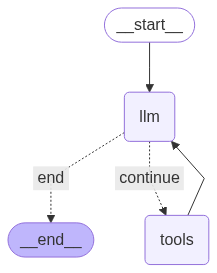

In [18]:
# visualize the graph using the draw_mermaid_png method
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# create initial message dictionary 
inputs = {"messages": [("user", f"What is the weather in Berlin on {datetime.today()}?")]}

# call graph with streaming to see the steps 
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

What is the weather in Berlin on 2025-07-08 14:36:03.193579?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (7d132f59-7fcb-4c91-86c3-bfc6c3519b2b)
 Call ID: 7d132f59-7fcb-4c91-86c3-bfc6c3519b2b
  Args:
    date: 2025-07-08
    location: Berlin
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-07-08T00:00': 16.3, '2025-07-08T01:00': 15.5, '2025-07-08T02:00': 15.4, '2025-07-08T03:00': 15.1, '2025-07-08T04:00': 14.6, '2025-07-08T05:00': 14.2, '2025-07-08T06:00': 14.1, '2025-07-08T07:00': 15.0, '2025-07-08T08:00': 16.4, '2025-07-08T09:00': 17.3, '2025-07-08T10:00': 18.3, '2025-07-08T11:00': 19.0, '2025-07-08T12:00': 19.7, '2025-07-08T13:00': 19.5, '2025-07-08T14:00': 19.2, '2025-07-08T15:00': 20.3, '2025-07-08T16:00': 20.7, '2025-07-08T17:00': 20.3, '2025-07-08T18:00': 19.5, '